In [2]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

In [3]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
findings = ["Atelectasis", "Effusion"]

In [4]:
df = pd.read_csv("/Users/smritisrivastava/Desktop/my research paper/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [5]:
import os
import pandas as pd
import shutil

# Constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
rootdir = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/"
labels_csv = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/labels.csv"
findings = ["Atelectasis", "Effusion"]

# Load labels
df = pd.read_csv(labels_csv)

def process_class(finding):
    finding_cap = finding.capitalize()
    
    # Filter positives and negatives
    positives = df.loc[df["label"] == finding_cap]
    negatives = df.loc[df["label"] == "No Finding"]
    n = len(positives)

    if n == 0:
        print(f"No studies found for {finding_cap}! Maybe check your spelling?")
        return

    # Calculate split sizes
    TRAIN_N = int(n * TRAIN_RATIO)
    TEST_N = int(n * TEST_RATIO)

    print(f"For class {finding_cap}: Train size = {TRAIN_N}, Test size = {TEST_N}")

    # Prepare labels
    train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
    test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:]])

    # Create directories
    os.makedirs(os.path.join(rootdir, finding_cap, "train", "positive"), exist_ok=True)
    os.makedirs(os.path.join(rootdir, finding_cap, "train", "negative"), exist_ok=True)
    os.makedirs(os.path.join(rootdir, finding_cap, "test", "positive"), exist_ok=True)
    os.makedirs(os.path.join(rootdir, finding_cap, "test", "negative"), exist_ok=True)

    # Copy images to directories
    for idx, image in positives[:TRAIN_N].iterrows():
        source = os.path.join(rootdir, image["filename"])
        dst = os.path.join(rootdir, finding_cap, "train", "positive", image["filename"])
        shutil.copy(source, dst)

    for idx, image in positives[TRAIN_N:].iterrows():
        source = os.path.join(rootdir, image["filename"])
        dst = os.path.join(rootdir, finding_cap, "test", "positive", image["filename"])
        shutil.copy(source, dst)

    for idx, image in negatives[:TRAIN_N].iterrows():
        source = os.path.join(rootdir, image["filename"])
        dst = os.path.join(rootdir, finding_cap, "train", "negative", image["filename"])
        shutil.copy(source, dst)

    for idx, image in negatives[TRAIN_N:].iterrows():
        source = os.path.join(rootdir, image["filename"])
        dst = os.path.join(rootdir, finding_cap, "test", "negative", image["filename"])
        shutil.copy(source, dst)

    print(f"Done moving images for {finding_cap}!")

# Process each finding
for finding in findings:
    process_class(finding)


For class Atelectasis: Train size = 144, Test size = 36
Done moving images for Atelectasis!
For class Effusion: Train size = 122, Test size = 30
Done moving images for Effusion!


Processing images for class: Atelectasis
Loaded images into memory.


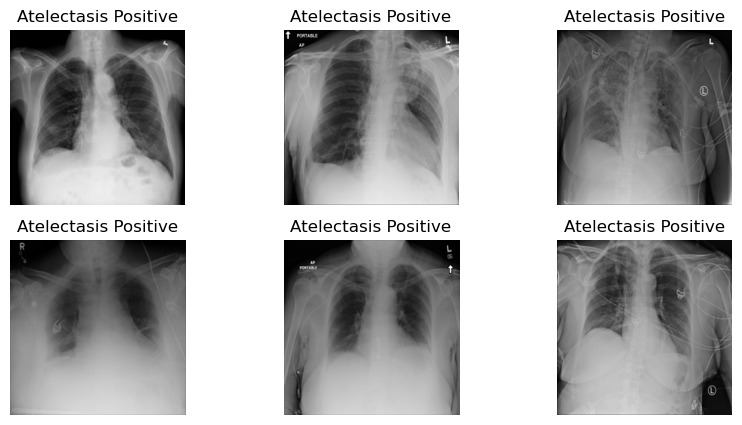

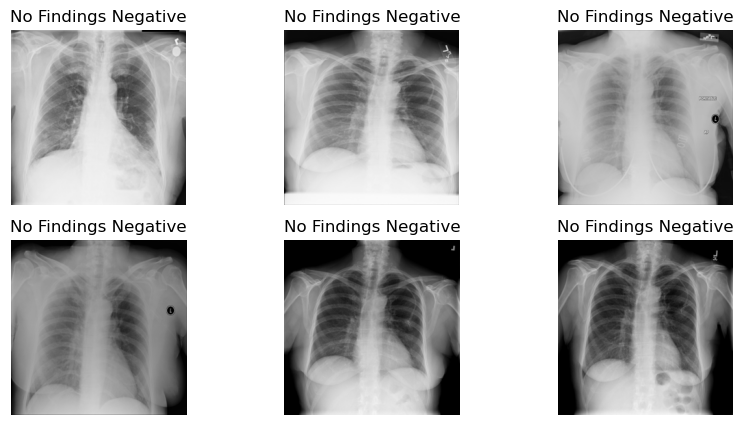

Processing images for class: Effusion
Loaded images into memory.


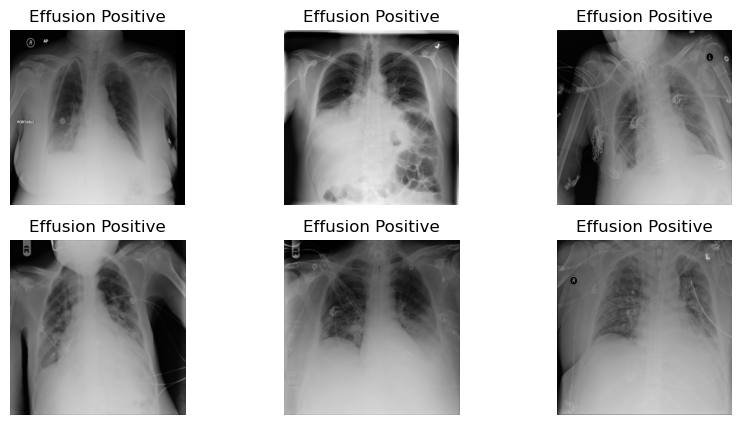

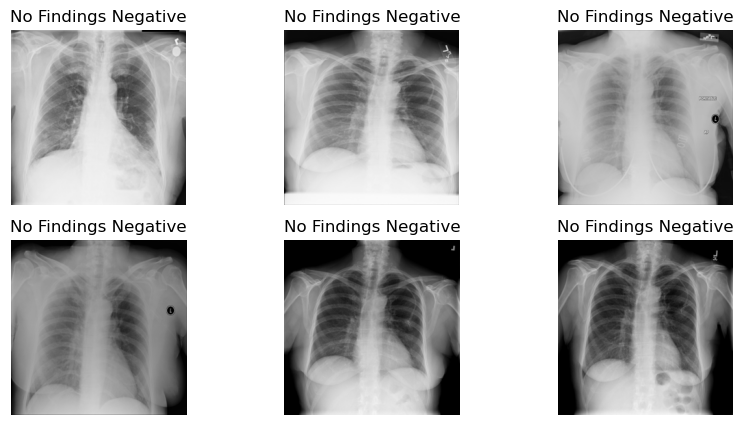

In [6]:
# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
rootdir = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/"
labels_csv = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/labels.csv"
df = pd.read_csv(labels_csv)

def load_image_into_numpy_array(image):
    return np.array(image)

def load_and_display_images(finding):
    print(f"Processing images for class: {finding}")
    
    # Define paths for positive and negative images
    positives = df.loc[df["label"] == finding.capitalize()]
    negatives = df.loc[df["label"] == "No Finding"]

    positive_imgs, negative_imgs = [], []

    # Load positive images
    for idx, row in positives[:6].iterrows():
        image_path = os.path.join(rootdir, row["filename"])
        try:
            image = Image.open(image_path).convert('L').convert('RGB').resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            positive_imgs.append(load_image_into_numpy_array(image))
        except FileNotFoundError:
            print(f"Error: File not found - {image_path}")

    # Load negative images
    for idx, row in negatives[:6].iterrows():
        image_path = os.path.join(rootdir, row["filename"])
        try:
            image = Image.open(image_path).convert('L').convert('RGB').resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            negative_imgs.append(load_image_into_numpy_array(image))
        except FileNotFoundError:
            print(f"Error: File not found - {image_path}")

    print("Loaded images into memory.")
    
    # Plot positive images
    plt.figure(figsize=(10, 5))
    for idx, img in enumerate(positive_imgs[:6]):
        plt.subplot(2, 3, idx+1)
        plt.title(f"{finding} Positive")
        plt.imshow(img)
        plt.axis('off')
    plt.show()

    # Plot negative images
    plt.figure(figsize=(10, 5))
    for idx, img in enumerate(negative_imgs[:6]):
        plt.subplot(2, 3, idx+1)
        plt.title("No Findings Negative")
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Process and display images for each finding
findings = ["Atelectasis", "Effusion"]
for finding in findings:
    load_and_display_images(finding)


In [7]:
def create_and_compile_model():
    pre_trained_model = InceptionV3(
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

    for layer in pre_trained_model.layers:
        layer.trainable = False

    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output

    x = layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
    x = layers.Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dropout(0.2)(x)  # Add a dropout rate of 0.2
    x = layers.Dense(2, activation='softmax')(x)  # Change to 2 units for binary classification and softmax activation

    model = Model(pre_trained_model.input, x)  # Configure and compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create and compile model for Atelectasis
model_atelectasis = create_and_compile_model()
print("Done compiling the model for Atelectasis!")

# Create and compile model for Effusion
model_effusion = create_and_compile_model()
print("Done compiling the model for Effusion!")


Done compiling the model for Atelectasis!
Done compiling the model for Effusion!


In [8]:
def setup_directories(finding):
    base_dir = rootdir = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/"
    train_dir = os.path.join(base_dir, finding, 'train')
    test_dir = os.path.join(base_dir, finding, 'test')

    train_pos_dir = os.path.join(train_dir, 'positive')
    train_neg_dir = os.path.join(train_dir, 'negative')
    test_pos_dir = os.path.join(test_dir, 'positive')
    test_neg_dir = os.path.join(test_dir, 'negative')

    return {
        "train_dir": train_dir,
        "test_dir": test_dir,
        "train_pos_dir": train_pos_dir,
        "train_neg_dir": train_neg_dir,
        "test_pos_dir": test_pos_dir,
        "test_neg_dir": test_neg_dir
    }

# Setup directories for atelectasis
directories_atelectasis = setup_directories("Atelectasis")
print("Directories setup for Atelectasis:", directories_atelectasis)

# Setup directories for effusion
directories_effusion = setup_directories("Effusion")
print("Directories setup for Effusion:", directories_effusion)
 

Directories setup for Atelectasis: {'train_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/train', 'test_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/test', 'train_pos_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/train/positive', 'train_neg_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/train/negative', 'test_pos_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/test/positive', 'test_neg_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/test/negative'}
Directories setup for Effusion: {'train_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Effusion/train', 'test_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Effusion/test', 'train_pos_dir': '/Users/smritisrivastava/Desktop/my research paper/medical-a

In [8]:
# Data augmentation parameters for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1./255)

# Function to set up data generators for a class
def setup_data_generators(directories, batch_size=32):
    train_generator = train_datagen.flow_from_directory(
        directories['train_dir'],
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical'
        )

    val_generator = val_datagen.flow_from_directory(
        directories['test_dir'],
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical'
        )

    return train_generator, val_generator

# Setup data generators for atelectasis
train_generator_atelectasis, val_generator_atelectasis = setup_data_generators(directories_atelectasis)
print("Data generators set up for Atelectasis")

# Setup data generators for effusion
train_generator_effusion, val_generator_effusion = setup_data_generators(directories_effusion)
print("Data generators set up for Effusion")


Found 288 images belonging to 2 classes.
Found 872 images belonging to 2 classes.
Data generators set up for Atelectasis
Found 244 images belonging to 2 classes.
Found 889 images belonging to 2 classes.
Data generators set up for Effusion


In [9]:
# Fit model for Atelectasis
history_atelectasis = model_atelectasis.fit(
    train_generator_atelectasis,
    steps_per_epoch=len(train_generator_atelectasis),
    epochs=20,
    validation_data=val_generator_atelectasis,
    validation_steps=len(val_generator_atelectasis),
    verbose=2
)


Epoch 1/20
9/9 - 36s - loss: 15.9236 - accuracy: 0.5035 - val_loss: 4.4439 - val_accuracy: 0.1044 - 36s/epoch - 4s/step
Epoch 2/20
9/9 - 36s - loss: 4.0813 - accuracy: 0.5417 - val_loss: 0.8655 - val_accuracy: 0.6858 - 36s/epoch - 4s/step
Epoch 3/20
9/9 - 35s - loss: 2.3396 - accuracy: 0.5556 - val_loss: 0.4409 - val_accuracy: 0.8647 - 35s/epoch - 4s/step
Epoch 4/20
9/9 - 35s - loss: 1.7109 - accuracy: 0.6111 - val_loss: 0.9031 - val_accuracy: 0.7248 - 35s/epoch - 4s/step
Epoch 5/20
9/9 - 35s - loss: 0.9950 - accuracy: 0.7083 - val_loss: 1.3146 - val_accuracy: 0.5528 - 35s/epoch - 4s/step
Epoch 6/20
9/9 - 35s - loss: 0.8747 - accuracy: 0.6597 - val_loss: 2.4271 - val_accuracy: 0.2064 - 35s/epoch - 4s/step
Epoch 7/20
9/9 - 36s - loss: 0.6733 - accuracy: 0.6875 - val_loss: 1.6356 - val_accuracy: 0.2179 - 36s/epoch - 4s/step
Epoch 8/20
9/9 - 37s - loss: 0.5482 - accuracy: 0.7396 - val_loss: 1.1774 - val_accuracy: 0.2752 - 37s/epoch - 4s/step
Epoch 9/20
9/9 - 37s - loss: 0.4965 - accuracy:

In [10]:
# Fit model for Effusion
history_effusion = model_effusion.fit(
    train_generator_effusion,
    steps_per_epoch=len(train_generator_effusion),
    epochs=20,
    validation_data=val_generator_effusion,
    validation_steps=len(val_generator_effusion),
    verbose=2
)


Epoch 1/20
8/8 - 44s - loss: 14.8860 - accuracy: 0.4713 - val_loss: 0.3653 - val_accuracy: 0.9111 - 44s/epoch - 6s/step
Epoch 2/20
8/8 - 41s - loss: 4.5371 - accuracy: 0.5820 - val_loss: 7.3035 - val_accuracy: 0.2205 - 41s/epoch - 5s/step
Epoch 3/20
8/8 - 40s - loss: 2.7861 - accuracy: 0.6352 - val_loss: 5.5662 - val_accuracy: 0.2520 - 40s/epoch - 5s/step
Epoch 4/20
8/8 - 38s - loss: 1.1407 - accuracy: 0.7500 - val_loss: 3.1079 - val_accuracy: 0.4049 - 38s/epoch - 5s/step
Epoch 5/20
8/8 - 40s - loss: 0.8941 - accuracy: 0.7705 - val_loss: 4.0634 - val_accuracy: 0.2902 - 40s/epoch - 5s/step
Epoch 6/20
8/8 - 38s - loss: 0.7647 - accuracy: 0.8033 - val_loss: 1.1233 - val_accuracy: 0.6839 - 38s/epoch - 5s/step
Epoch 7/20
8/8 - 41s - loss: 0.7842 - accuracy: 0.7787 - val_loss: 2.8533 - val_accuracy: 0.3858 - 41s/epoch - 5s/step
Epoch 8/20
8/8 - 44s - loss: 0.5984 - accuracy: 0.8033 - val_loss: 2.6342 - val_accuracy: 0.4106 - 44s/epoch - 5s/step
Epoch 9/20
8/8 - 42s - loss: 0.5446 - accuracy:

In [12]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os

In [13]:
# Define image dimensions
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 256, 256, 3
INPUT_DIM = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)


In [14]:

base_dir = "/Users/smritisrivastava/Desktop/my research paper/medical-ai/images"

In [15]:
# Function to set up data generators for each class
def setup_data_generators(base_dir, disease, batch_size=32):
    train_dir = os.path.join(base_dir, disease, 'train')
    test_dir = os.path.join(base_dir, disease, 'test')

    # Ensure directories exist
    assert os.path.exists(train_dir), f"Training directory does not exist: {train_dir}"
    assert os.path.exists(test_dir), f"Testing directory does not exist: {test_dir}"

    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No data augmentation for validation data
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, val_generator


In [16]:
# Set up data generators for Atelectasis
train_generator_atelectasis, val_generator_atelectasis = setup_data_generators(base_dir, 'Atelectasis')
print("Data generators set up for Atelectasis")

# Set up data generators for Effusion
train_generator_effusion, val_generator_effusion = setup_data_generators(base_dir, 'Effusion')
print("Data generators set up for Effusion")

Found 288 images belonging to 2 classes.
Found 872 images belonging to 2 classes.
Data generators set up for Atelectasis
Found 244 images belonging to 2 classes.
Found 889 images belonging to 2 classes.
Data generators set up for Effusion


In [17]:
# Create and compile the DenseNet201 model with transfer learning
def create_and_compile_model():
    base_model = DenseNet201(
        input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
        weights='imagenet',
        include_top=False
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout to help with overfitting
    x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create and compile the model
    model = Model(base_model.input, x)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and compile the model for Atelectasis and Effusion
model_atelectasis = create_and_compile_model()
model_effusion = create_and_compile_model()
print("Models created and compiled")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Function to train and capture history

Models created and compiled


Training DenseNet201 model for Atelectasis...
Epoch 1/25


/Users/smritisrivastava/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 81s - loss: 43.7139 - accuracy: 0.4931 - val_loss: 28.1790 - val_accuracy: 0.0436 - lr: 0.0010 - 81s/epoch - 9s/step
Epoch 2/25
9/9 - 74s - loss: 15.8310 - accuracy: 0.5174 - val_loss: 26.2703 - val_accuracy: 0.0585 - lr: 0.0010 - 74s/epoch - 8s/step
Epoch 3/25
9/9 - 76s - loss: 11.7578 - accuracy: 0.5382 - val_loss: 18.4541 - val_accuracy: 0.1422 - lr: 0.0010 - 76s/epoch - 8s/step
Epoch 4/25
9/9 - 77s - loss: 7.0423 - accuracy: 0.5764 - val_loss: 2.4826 - val_accuracy: 0.7798 - lr: 0.0010 - 77s/epoch - 9s/step
Epoch 5/25
9/9 - 74s - loss: 6.1857 - accuracy: 0.6181 - val_loss: 5.2793 - val_accuracy: 0.5172 - lr: 0.0010 - 74s/epoch - 8s/step
Epoch 6/25
9/9 - 75s - loss: 4.7465 - accuracy: 0.6215 - val_loss: 6.1111 - val_accuracy: 0.3521 - lr: 0.0010 - 75s/epoch - 8s/step
Epoch 7/25
9/9 - 79s - loss: 2.8512 - accuracy: 0.6354 - val_loss: 1.5400 - val_accuracy: 0.7305 - lr: 0.0010 - 79s/epoch - 9s/step
Epoch 8/25
9/9 - 78s - loss: 1.7428 - accuracy: 0.6771 - val_loss: 1.5124 - val_a

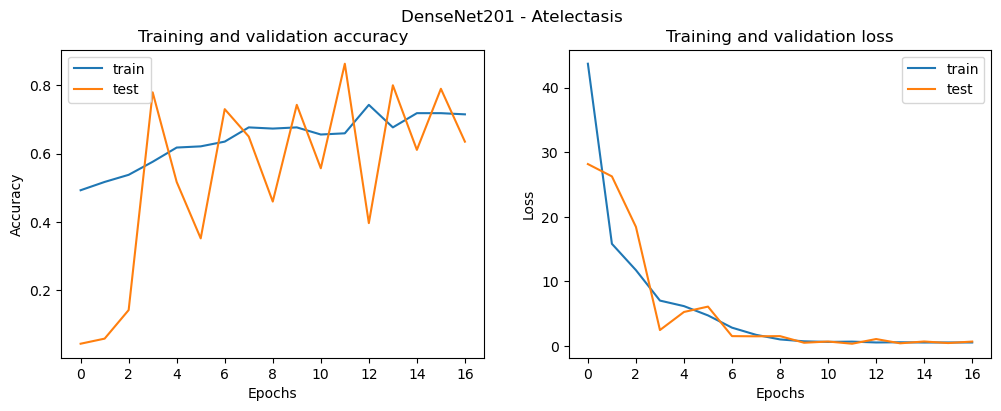

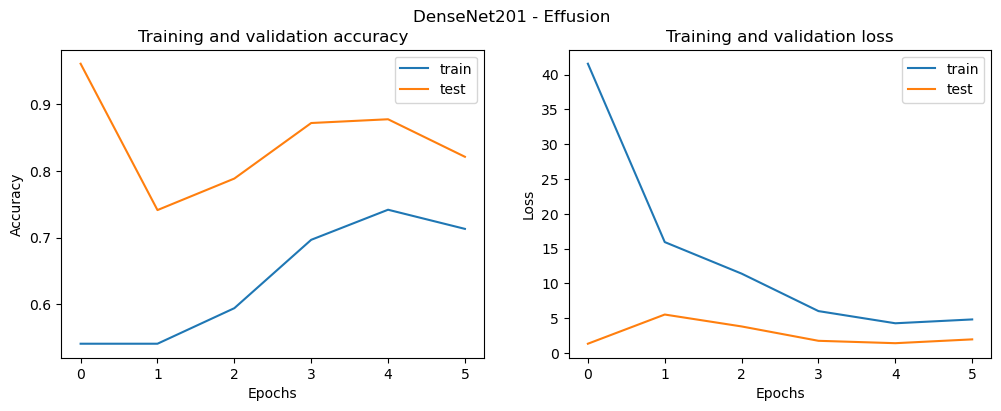

In [21]:
EPOCHS=25
def train_model(model, train_generator, val_generator, train_steps, val_steps, epochs=25):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=2
    )
    return history

# Train the model for Atelectasis
train_steps_atelectasis = len(train_generator_atelectasis)
val_steps_atelectasis = len(val_generator_atelectasis)
print(f"Training DenseNet201 model for Atelectasis...")
history_atelectasis = train_model(model_atelectasis, train_generator_atelectasis, val_generator_atelectasis, train_steps_atelectasis, val_steps_atelectasis, epochs=EPOCHS)

# Train the model for Effusion
train_steps_effusion = len(train_generator_effusion)
val_steps_effusion = len(val_generator_effusion)
print(f"Training DenseNet201 model for Effusion...")
history_effusion = train_model(model_effusion, train_generator_effusion, val_generator_effusion, train_steps_effusion, val_steps_effusion, epochs=EPOCHS)

# Print accuracies of both models
def print_accuracies(name, history):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    print(f"{name} model - Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

print_accuracies("DenseNet201 - Atelectasis", history_atelectasis)
print_accuracies("DenseNet201 - Effusion", history_effusion)

# Plot the curves
def plot_history(histories):
    for name, history in histories:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.suptitle(name)

        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="train")
        plt.plot(epochs, val_acc, label="test")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="train")
        plt.plot(epochs, val_loss, label="test")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

plot_history([("DenseNet201 - Atelectasis", history_atelectasis), ("DenseNet201 - Effusion", history_effusion)])

In [22]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_model(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, val_generator, train_steps, val_steps, epochs=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, checkpoint, reduce_lr],
        verbose=2
    )
    return history

def compute_metrics(model, generator, class_names):
    # Generate predictions
    y_pred_probs = model.predict(generator, steps=len(generator), verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=-1)
    y_true = generator.classes
    class_labels = class_names

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Compute F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute classification report
    class_report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    
    # Extract sensitivity (Recall for each class)
    sensitivity = {class_name: class_report[class_name]['recall'] for class_name in class_labels}

    # Compute specificity
    specificity = {}
    for i, class_name in enumerate(class_labels):
        tp = conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - tp)
        fp = np.sum(conf_matrix[:, i]) - tp
        specificity[class_name] = tn / (tn + fp) if (tn + fp) > 0 else 0

    return f1, conf_matrix, sensitivity, specificity

# Create models
model_atelectasis = create_model(num_classes=2)
model_effusion = create_model(num_classes=2)

# Example: Define data generators
train_generator_atelectasis = ImageDataGenerator().flow_from_directory('/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/train', target_size=(128, 128), batch_size=32, class_mode='categorical')
val_generator_atelectasis = ImageDataGenerator().flow_from_directory('/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/Atelectasis/test', target_size=(128, 128), batch_size=32, class_mode='categorical')
train_generator_effusion = ImageDataGenerator().flow_from_directory('/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/effusion/train', target_size=(128, 128), batch_size=32, class_mode='categorical')
val_generator_effusion = ImageDataGenerator().flow_from_directory('/Users/smritisrivastava/Desktop/my research paper/medical-ai/images/effusion/test', target_size=(128, 128), batch_size=32, class_mode='categorical')

# Define training and validation steps
train_steps_atelectasis = len(train_generator_atelectasis)
val_steps_atelectasis = len(val_generator_atelectasis)
train_steps_effusion = len(train_generator_effusion)
val_steps_effusion = len(val_generator_effusion)

# Train the models
history_atelectasis = train_model(model_atelectasis, train_generator_atelectasis, val_generator_atelectasis, train_steps_atelectasis, val_steps_atelectasis)
history_effusion = train_model(model_effusion, train_generator_effusion, val_generator_effusion, train_steps_effusion, val_steps_effusion)

# Compute metrics for Atelectasis model
class_names_atelectasis = ['Atelectasis', 'No Finding']
f1_atelectasis, conf_matrix_atelectasis, sensitivity_atelectasis, specificity_atelectasis = compute_metrics(model_atelectasis, val_generator_atelectasis, class_names_atelectasis)

print("DenseNet201 - Atelectasis Metrics")
print(f"F1 Score: {f1_atelectasis:.4f}")
print("Confusion Matrix:")
print(conf_matrix_atelectasis)
print("Sensitivity:", sensitivity_atelectasis)
print("Specificity:", specificity_atelectasis)

# Compute metrics for Effusion model
class_names_effusion = ['Effusion', 'No Finding']
f1_effusion, conf_matrix_effusion, sensitivity_effusion, specificity_effusion = compute_metrics(model_effusion, val_generator_effusion, class_names_effusion)

print("DenseNet201 - Effusion Metrics")
print(f"F1 Score: {f1_effusion:.4f}")
print("Confusion Matrix:")
print(conf_matrix_effusion)
print("Sensitivity:", sensitivity_effusion)
print("Specificity:", specificity_effusion)


Found 288 images belonging to 2 classes.
Found 872 images belonging to 2 classes.
Found 244 images belonging to 2 classes.
Found 889 images belonging to 2 classes.
Epoch 1/25
9/9 - 49s - loss: 1.6215 - accuracy: 0.5660 - val_loss: 0.3778 - val_accuracy: 0.9587 - lr: 0.0010 - 49s/epoch - 5s/step
Epoch 2/25
9/9 - 34s - loss: 0.6757 - accuracy: 0.7674 - val_loss: 151.1312 - val_accuracy: 0.0413 - lr: 0.0010 - 34s/epoch - 4s/step
Epoch 3/25
9/9 - 35s - loss: 0.4436 - accuracy: 0.8229 - val_loss: 5.0646 - val_accuracy: 0.9587 - lr: 0.0010 - 35s/epoch - 4s/step
Epoch 4/25
9/9 - 35s - loss: 0.2780 - accuracy: 0.8750 - val_loss: 2.4318 - val_accuracy: 0.9587 - lr: 0.0010 - 35s/epoch - 4s/step
Epoch 1/25
8/8 - 48s - loss: 1.2019 - accuracy: 0.7049 - val_loss: 22.4446 - val_accuracy: 0.0349 - lr: 0.0010 - 48s/epoch - 6s/step
Epoch 2/25
8/8 - 32s - loss: 0.6330 - accuracy: 0.8074 - val_loss: 0.9759 - val_accuracy: 0.6367 - lr: 0.0010 - 32s/epoch - 4s/step
Epoch 3/25
8/8 - 32s - loss: 0.3880 - acc

/Users/smritisrivastava/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smritisrivastava/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/smritisrivastava/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

28/28 [==============================] - 17s 539ms/step
DenseNet201 - Effusion Metrics
F1 Score: 0.9469
Confusion Matrix:
[[856   2]
 [ 31   0]]
Sensitivity: {'Effusion': 0.9976689976689976, 'No Finding': 0.0}
Specificity: {'Effusion': 0.0, 'No Finding': 0.9976689976689976}


In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet201
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Root directory of the dataset
root_dir = '/Users/smritisrivastava/Desktop/my research paper/medical-ai'

# Image directories for Atelectasis
atelectasis_train_dir = os.path.join(root_dir, 'images/Atelectasis/train')
atelectasis_val_dir = os.path.join(root_dir, 'images/Atelectasis/test')

# Image directories for Effusion
effusion_train_dir = os.path.join(root_dir, 'images/Effusion/train')
effusion_val_dir = os.path.join(root_dir, 'images/Effusion/test')

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation and test (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator for Atelectasis
atelectasis_train_generator = train_datagen.flow_from_directory(
    atelectasis_train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator for Atelectasis
atelectasis_val_generator = val_test_datagen.flow_from_directory(
    atelectasis_val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Training data generator for Effusion
effusion_train_generator = train_datagen.flow_from_directory(
    effusion_train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator for Effusion
effusion_val_generator = val_test_datagen.flow_from_directory(
    effusion_val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Calculate class weights for Atelectasis
atelectasis_classes = atelectasis_train_generator.classes
atelectasis_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(atelectasis_classes),
    y=atelectasis_classes
)
atelectasis_class_weights_dict = dict(enumerate(atelectasis_class_weights))

# Calculate class weights for Effusion
effusion_classes = effusion_train_generator.classes
effusion_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(effusion_classes),
    y=effusion_classes
)
effusion_class_weights_dict = dict(enumerate(effusion_class_weights))

# Model setup for Atelectasis
atelectasis_base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
atelectasis_x = atelectasis_base_model.output
atelectasis_x = GlobalAveragePooling2D()(atelectasis_x)
atelectasis_x = Dropout(0.5)(atelectasis_x)  # Dropout layer
atelectasis_predictions = Dense(atelectasis_train_generator.num_classes, activation='softmax')(atelectasis_x)

atelectasis_model = Model(inputs=atelectasis_base_model.input, outputs=atelectasis_predictions)

# Compile the model for Atelectasis
atelectasis_model.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='categorical_crossentropy',  # Use categorical_crossentropy
                          metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks for Atelectasis
atelectasis_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
atelectasis_checkpoint = ModelCheckpoint(os.path.join(root_dir, 'best_model_atelectasis.h5'),
                                         monitor='val_loss', save_best_only=True)
atelectasis_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Model training for Atelectasis
atelectasis_history = atelectasis_model.fit(
    atelectasis_train_generator,
    steps_per_epoch=atelectasis_train_generator.samples // atelectasis_train_generator.batch_size,
    epochs=25,
    validation_data=atelectasis_val_generator,
    validation_steps=atelectasis_val_generator.samples // atelectasis_val_generator.batch_size,
    callbacks=[atelectasis_early_stopping, atelectasis_checkpoint, atelectasis_reduce_lr],
    class_weight=atelectasis_class_weights_dict,
    verbose=2
)

# Model setup for Effusion
effusion_base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
effusion_x = effusion_base_model.output
effusion_x = GlobalAveragePooling2D()(effusion_x)
effusion_x = Dropout(0.5)(effusion_x)  # Dropout layer
effusion_predictions = Dense(effusion_train_generator.num_classes, activation='softmax')(effusion_x)

effusion_model = Model(inputs=effusion_base_model.input, outputs=effusion_predictions)

# Compile the model for Effusion
effusion_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',  # Use categorical_crossentropy
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Callbacks for Effusion
effusion_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
effusion_checkpoint = ModelCheckpoint(os.path.join(root_dir, 'best_model_effusion.h5'),
                                      monitor='val_loss', save_best_only=True)
effusion_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Model training for Effusion
effusion_history = effusion_model.fit(
    effusion_train_generator,
    steps_per_epoch=effusion_train_generator.samples // effusion_train_generator.batch_size,
    epochs=25,
    validation_data=effusion_val_generator,
    validation_steps=effusion_val_generator.samples // effusion_val_generator.batch_size,
    callbacks=[effusion_early_stopping, effusion_checkpoint, effusion_reduce_lr],
    class_weight=effusion_class_weights_dict,
    verbose=2
)

# Evaluation function
def evaluate_model(model, test_generator, title):
    # Model evaluation
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=1)
    print(f"{title} - Test Accuracy: {test_accuracy:.4f}")
    print(f"{title} - Test Precision: {test_precision:.4f}")
    print(f"{title} - Test Recall: {test_recall:.4f}")

    # Predictions and Confusion Matrix
    test_generator.reset()
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    confusion_mtx = confusion_matrix(true_classes, predicted_classes)
    print(f"{title} - Confusion Matrix")
    print(confusion_mtx)

    # Classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f"{title} - Classification Report")
    print(report)

# Test data generators
atelectasis_test_generator = val_test_datagen.flow_from_directory(
    atelectasis_val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

effusion_test_generator = val_test_datagen.flow_from_directory(
    effusion_val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Model evaluation for Atelectasis
evaluate_model(atelectasis_model, atelectasis_test_generator, "Atelectasis")

# Model evaluation for Effusion
evaluate_model(effusion_model, effusion_test_generator, "Effusion")


Found 288 images belonging to 2 classes.
Found 872 images belonging to 2 classes.
Found 244 images belonging to 2 classes.
Found 889 images belonging to 2 classes.
Epoch 1/25


/Users/smritisrivastava/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 - 174s - loss: 0.7706 - accuracy: 0.5764 - precision_2: 0.5764 - recall_2: 0.5764 - val_loss: 0.3894 - val_accuracy: 0.9109 - val_precision_2: 0.9109 - val_recall_2: 0.9109 - lr: 1.0000e-04 - 174s/epoch - 19s/step
Epoch 2/25
9/9 - 173s - loss: 0.5930 - accuracy: 0.7049 - precision_2: 0.7049 - recall_2: 0.7049 - val_loss: 0.3384 - val_accuracy: 0.9097 - val_precision_2: 0.9097 - val_recall_2: 0.9097 - lr: 1.0000e-04 - 173s/epoch - 19s/step
Epoch 3/25
9/9 - 172s - loss: 0.4258 - accuracy: 0.7951 - precision_2: 0.7951 - recall_2: 0.7951 - val_loss: 0.3685 - val_accuracy: 0.8796 - val_precision_2: 0.8796 - val_recall_2: 0.8796 - lr: 1.0000e-04 - 172s/epoch - 19s/step
Epoch 4/25
9/9 - 183s - loss: 0.3754 - accuracy: 0.8472 - precision_2: 0.8472 - recall_2: 0.8472 - val_loss: 0.3321 - val_accuracy: 0.8843 - val_precision_2: 0.8843 - val_recall_2: 0.8843 - lr: 1.0000e-04 - 183s/epoch - 20s/step
Epoch 5/25
9/9 - 202s - loss: 0.3029 - accuracy: 0.8785 - precision_2: 0.8785 - recall_2: 0.878

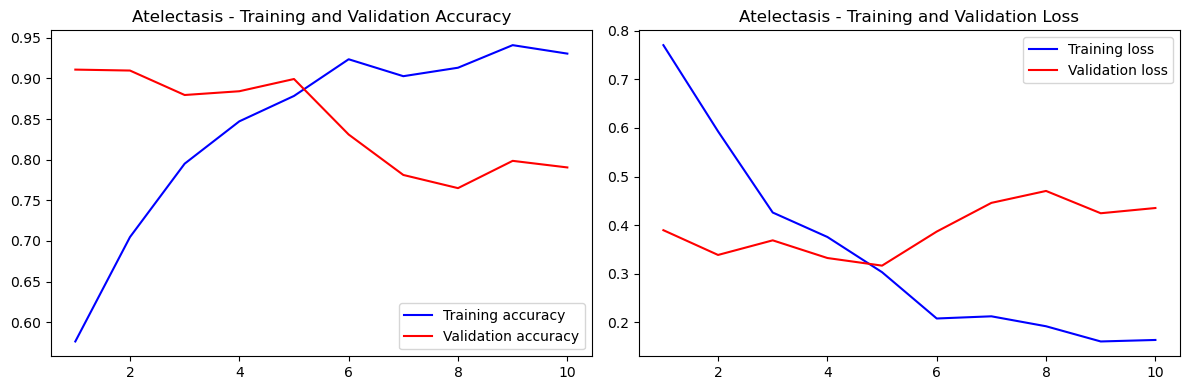

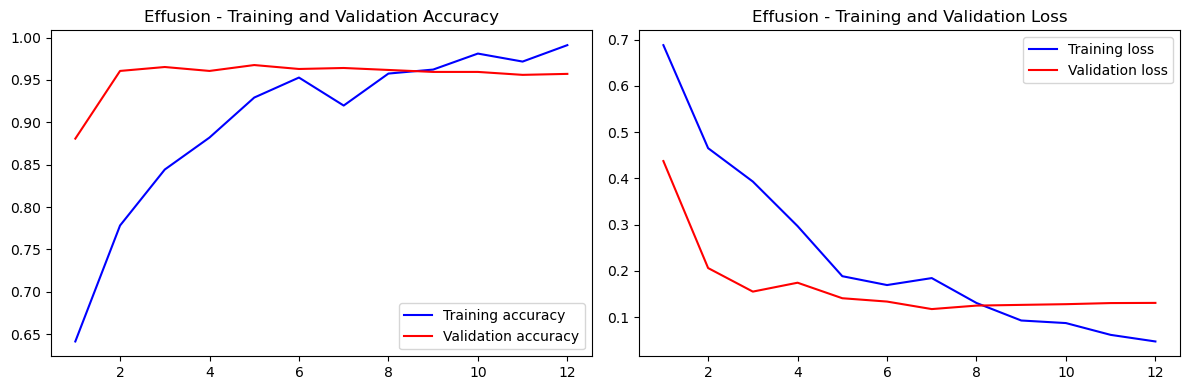

In [10]:
# Function to plot graphs
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training and validation accuracy and loss for Atelectasis
plot_history(atelectasis_history, "Atelectasis")

# Plot training and validation accuracy and loss for Effusion
plot_history(effusion_history, "Effusion")